In [1]:
# pip install optuna

In [2]:
# pip install optuna-integration[tfkeras]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
import spacy
import nltk
# import torch
import optuna
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from optuna.integration import TFKerasPruningCallback
from optuna.samplers import TPESampler

# !pip install transformers torch pandas scikit-learn

Reading the Dataframe

In [4]:
df = pd.read_json("train.json")
df.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


Preprocessing the dataframe

In [5]:
#Removal of outlier
upper_bound = np.percentile(df["price"].values, 99.9)
df_filtered = df[df["price"] <= upper_bound]

In [ ]:
# Step 2: Convert 'created' column to datetime format
df_filtered['created'] = pd.to_datetime(df_filtered['created'])

# Step 3: Extract useful components from the 'created' column
df_filtered['year'] = df_filtered['created'].dt.year
df_filtered['month'] = df_filtered['created'].dt.month
df_filtered['day'] = df_filtered['created'].dt.day
df_filtered['hour'] = df_filtered['created'].dt.hour
df_filtered['minute'] = df_filtered['created'].dt.minute
df_filtered['second'] = df_filtered['created'].dt.second

# Drop the original 'created' column as it's no longer needed
df_filtered.drop(columns=['created'], inplace=True)
df_filtered.drop(columns=['manager_id'], inplace=True)

# Step 4: Process list columns ('features' and 'photos')
# For 'features' column: Count the number of features in the list
df_filtered['features_count'] = df_filtered['features'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# For 'photos' column: Count the number of photos in the list
df_filtered['photos_count'] = df_filtered['photos'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# Drop original 'features' and 'photos' columns
# df_filtered.drop(columns=['features', 'photos'], inplace=True)
df_filtered.drop(columns=['photos'], inplace=True)

C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\1629276100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['created'] = pd.to_datetime(df_filtered['created'])
C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\1629276100.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = df_filtered['created'].dt.year
C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\1629276100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [ ]:
# Encode target variable into numerical values
label_encoder = LabelEncoder()

df_filtered['interest_level_encoded'] = label_encoder.fit_transform(df_filtered['interest_level'])

# Label Encoding for categorical variables
categorical_features = ['building_id']
for feature in categorical_features:
    df_filtered[f'{feature}_encoded'] = label_encoder.fit_transform(df_filtered[feature])
df_filtered.head()

C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\490976259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['interest_level_encoded'] = label_encoder.fit_transform(df_filtered['interest_level'])
C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\490976259.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[f'{feature}_encoded'] = label_encoder.fit_transform(df_filtered[feature])


,bathrooms,bedrooms,building_id,description,display_address,features,latitude,listing_id,longitude,price,...,year,month,day,hour,minute,second,features_count,photos_count,interest_level_encoded,building_id_encoded
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,2400,...,2016,6,16,5,55,27,0,0,2,3934
6,1.0,2,b8e75fc949a6cd8225b455648a951712,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,3800,...,2016,6,1,5,44,33,0,0,1,5486
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,3495,...,2016,6,14,15,19,59,0,0,2,6086
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,3000,...,2016,6,24,7,54,24,0,0,2,2427
15,1.0,0,bfb9405149bfff42a92980b594c28234,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2795,...,2016,6,28,3,50,23,0,0,1,5681


Creating the correlation matrix

In [11]:
print(df_filtered.columns)

Index(['bathrooms', 'bedrooms', 'building_id', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'price', 'street_address', 'interest_level', 'year', 'month', 'day',
       'hour', 'minute', 'second', 'features_count', 'photos_count',
       'interest_level_encoded', 'building_id_encoded'],
      dtype='object')


In [13]:
# Ensure necessary NLTK data packages are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join back to string
    return ' '.join(tokens)

# Apply preprocessing to 'description'
df_filtered['description_clean'] = df_filtered['description'].apply(preprocess_text)

# Handle 'features' column
# Since 'features' is a list, first convert it to a string
df_filtered['features_clean'] = df_filtered['features'].apply(lambda x: ' '.join(x)).apply(preprocess_text)

# Display the cleaned text
df_filtered[['description_clean', 'features_clean']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MITALI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MITALI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\3292981757.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['description_clean'] = df_filtered['description'].apply(preprocess_text)
C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\3292981757.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,description_clean,features_clean
4,spacious 1 bedroom 1 bathroom williamsburgapar...,dining room prewar laundry building dishwasher...
6,brand new gut renovated true 2 bedroomfind hom...,doorman elevator laundry building dishwasher h...
9,flex 2 bedroom full pressurized walllooking pe...,doorman elevator laundry building laundry unit...
10,brand new 3 bedroom 15 bath apartmentenjoy fol...,
15,oversized studio w abundant closet available i...,doorman elevator fitness center laundry building


In [14]:
# Define maximum vocabulary size and sequence length for descriptions
max_vocab_size_desc = 10000
max_sequence_length_desc = 100

# Define maximum vocabulary size and sequence length for features
max_vocab_size_feat = 5000
max_sequence_length_feat = 20

# Initialize tokenizers
tokenizer_desc = Tokenizer(num_words=max_vocab_size_desc, oov_token="<OOV>")
tokenizer_feat = Tokenizer(num_words=max_vocab_size_feat, oov_token="<OOV>")

# Fit tokenizers on the cleaned text
tokenizer_desc.fit_on_texts(df_filtered['description_clean'])
tokenizer_feat.fit_on_texts(df_filtered['features_clean'])

# Convert texts to sequences
sequences_desc = tokenizer_desc.texts_to_sequences(df_filtered['description_clean'])
sequences_feat = tokenizer_feat.texts_to_sequences(df_filtered['features_clean'])

# Pad sequences
padded_desc = pad_sequences(sequences_desc, maxlen=max_sequence_length_desc, padding='post', truncating='post')
padded_feat = pad_sequences(sequences_feat, maxlen=max_sequence_length_feat, padding='post', truncating='post')

# Display the shape of the tokenized data
print(f"Description sequences shape: {padded_desc.shape}")
print(f"Features sequences shape: {padded_feat.shape}")

Description sequences shape: (49317, 100)
Features sequences shape: (49317, 20)


In [15]:
# Define the target variable 'y' and features 'X'
y = df_filtered['interest_level_encoded'].values
y_categorical = to_categorical(y)
X_structured = df_filtered.drop(columns=['interest_level', 'interest_level_encoded', 'building_id', 'description', 'display_address', 'features', 'listing_id', 'street_address', 'description_clean', 'features_clean']).values

# Split the data into 80% training set and 20% test set
X_structured_train, X_structured_test, padded_desc_train, padded_desc_test, padded_feat_train, padded_feat_test, y_train, y_test = train_test_split(
    X_structured, padded_desc, padded_feat, y_categorical, test_size=0.2, random_state=42, stratify=y
)

# Feature Scaling
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_structured_train)
X_test_scaled = x_scaler.transform(X_structured_test)

In [16]:
# Text input for 'description_clean'
desc_input = Input(shape=(max_sequence_length_desc,), name='description_input')
embedding_desc = Embedding(input_dim=max_vocab_size_desc, output_dim=128, input_length=max_sequence_length_desc)(desc_input)
lstm_desc = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedding_desc)

# Text input for 'features_clean'
feat_input = Input(shape=(max_sequence_length_feat,), name='features_input')
embedding_feat = Embedding(input_dim=max_vocab_size_feat, output_dim=64, input_length=max_sequence_length_feat)(feat_input)
lstm_feat = LSTM(32, dropout=0.2, recurrent_dropout=0.2)(embedding_feat)

# Structured data input
structured_input = Input(shape=(X_train_scaled.shape[1],), name='structured_input')
dense_structured = Dense(64, activation='relu')(structured_input)
dense_structured = Dropout(0.3)(dense_structured)

# Combine all processed inputs
combined = Concatenate()([lstm_desc, lstm_feat, dense_structured])

# Add additional layers if desired
dense1 = Dense(128, activation='relu')(combined)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)

# Output layer
output = Dense(y_train.shape[1], activation='linear')(drop2)  # `y_train.shape[1]` gives the number of classes

# Build the model
model = Model(inputs=[desc_input, feat_input, structured_input], outputs=output)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    # metrics=['mae', 'mse']
)

# Display the model summary
model.summary()

c:\Users\MITALI\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ description_input   │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features_input      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structured_input    │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ description_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 20, 64)    │    320,000 │ features_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        960 │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0],     │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     20,608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,691,843 (6.45 MB)

 Trainable params: 1,691,843 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    {
        'description_input': padded_desc_train,
        'features_input': padded_feat_train,
        'structured_input': X_train_scaled
    },
    y_train,
    epochs=50,  # Adjust epochs as needed
    batch_size=128,
    validation_data=(
        {
            'description_input': padded_desc_test,
            'features_input': padded_feat_test,
            'structured_input': X_test_scaled
        },
        y_test
    ),
    callbacks=[early_stop]
)

Epoch 1/50


c:\Users\MITALI\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['description_input', 'features_input', 'structured_input']. Received: the structure of inputs={'description_input': '*', 'features_input': '*', 'structured_input': '*'}
  warnings.warn(


309/309 ━━━━━━━━━━━━━━━━━━━━ 83s 216ms/step - accuracy: 0.2456 - loss: 3.1510 - val_accuracy: 0.6944 - val_loss: 0.8182
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 57s 185ms/step - accuracy: 0.6808 - loss: 1.0076 - val_accuracy: 0.6944 - val_loss: 0.8089
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 55s 178ms/step - accuracy: 0.6937 - loss: 0.8874 - val_accuracy: 0.6944 - val_loss: 0.7892
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 64s 207ms/step - accuracy: 0.6943 - loss: 0.8510 - val_accuracy: 0.6944 - val_loss: 0.7902
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 58s 186ms/step - accuracy: 0.6894 - loss: 0.8206 - val_accuracy: 0.6944 - val_loss: 0.7896
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 92s 218ms/step - accuracy: 0.6940 - loss: 0.8017 - val_accuracy: 0.6944 - val_loss: 0.7775
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 61s 198ms/step - accuracy: 0.6945 - loss: 0.7950 - val_accuracy: 0.6944 - val_loss: 0.7488
Epoch 8/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 69s 155ms/step - accuracy: 0.6960 - loss: 0.8404 - val

In [18]:
# Predict on test data
y_pred = model.predict({
    'description_input': padded_desc_test,
    'features_input': padded_feat_test,
    'structured_input': X_test_scaled
})

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

309/309 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


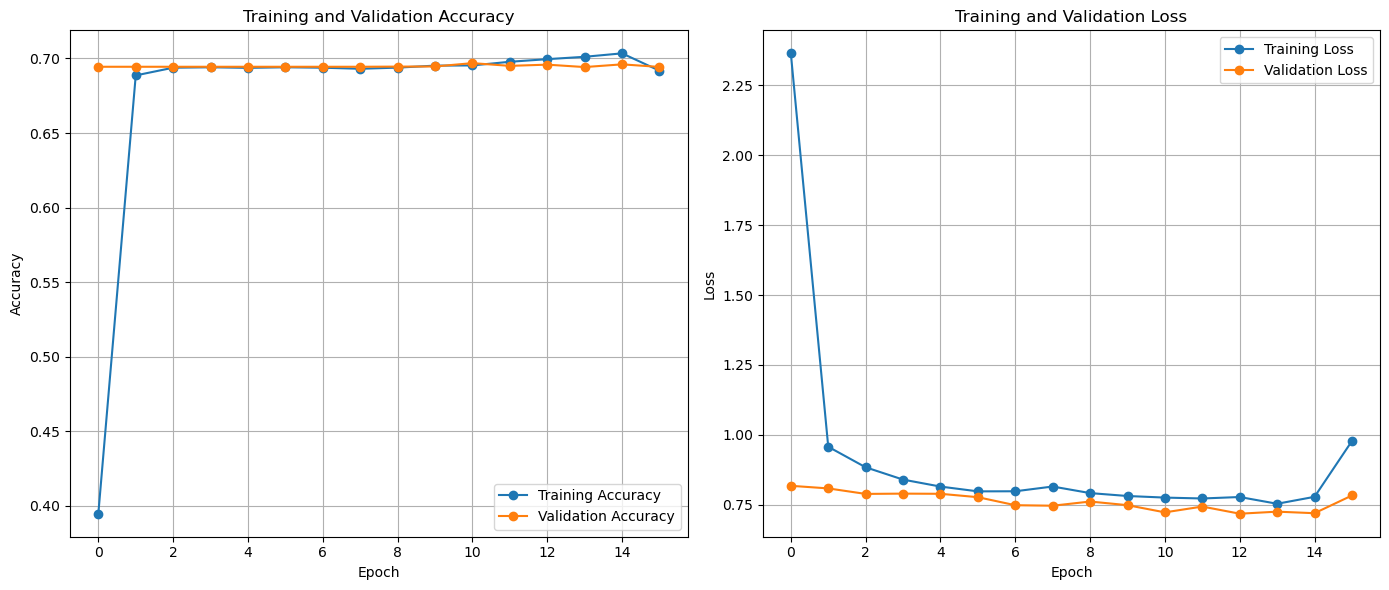

In [19]:
# Plotting Training and Validation Accuracy and Loss
def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

In [20]:
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1score = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1score}")

Accuracy: 0.6958637469586375
Precision: 0.5848166300019736
Recall: 0.6958637469586375
F1 Score: 0.59204221575934


c:\Users\MITALI\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optuna

In [21]:
def objective(trial):
    # Suggest hyperparameters
    embedding_dim_desc = trial.suggest_categorical('embedding_dim_desc', [64, 128, 256])
    embedding_dim_feat = trial.suggest_categorical('embedding_dim_feat', [32, 64, 128])
    lstm_units_desc = trial.suggest_categorical('lstm_units_desc', [64, 128, 256])
    lstm_units_feat = trial.suggest_categorical('lstm_units_feat', [32, 64, 128])
    dropout_lstm = trial.suggest_float('dropout_lstm', 0.1, 0.5)
    dropout_dense = trial.suggest_float('dropout_dense', 0.1, 0.5)
    dense_units = trial.suggest_categorical('dense_units', [64, 128, 256])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])

    # Build the model
    # Description input
    desc_input = Input(shape=(max_sequence_length_desc,), name='description_input')
    embedding_desc = Embedding(input_dim=max_vocab_size_desc, output_dim=embedding_dim_desc, input_length=max_sequence_length_desc)(desc_input)
    lstm_desc = LSTM(lstm_units_desc, dropout=dropout_lstm, recurrent_dropout=dropout_lstm)(embedding_desc)

    # Features input
    feat_input = Input(shape=(max_sequence_length_feat,), name='features_input')
    embedding_feat = Embedding(input_dim=max_vocab_size_feat, output_dim=embedding_dim_feat, input_length=max_sequence_length_feat)(feat_input)
    lstm_feat = LSTM(lstm_units_feat, dropout=dropout_lstm, recurrent_dropout=dropout_lstm)(embedding_feat)

    # Structured data input
    structured_input = Input(shape=(X_train_scaled.shape[1],), name='structured_input')
    dense_structured = Dense(dense_units, activation=activation)(structured_input)
    dense_structured = Dropout(dropout_dense)(dense_structured)

    # Combine all processed inputs
    combined = Concatenate()([lstm_desc, lstm_feat, dense_structured])

    # Additional layers
    dense1 = Dense(dense_units, activation=activation)(combined)
    drop1 = Dropout(dropout_dense)(dense1)
    dense2 = Dense(dense_units, activation=activation)(drop1)
    drop2 = Dropout(dropout_dense)(dense2)

    # Output layer
    output = Dense(y_train.shape[1], activation='linear')(drop2)

    # Build the model
    model = Model(inputs=[desc_input, feat_input, structured_input], outputs=output)

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
        # metrics=['mae', 'mse']
    )

    # Early stopping and pruning
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    pruning_callback = TFKerasPruningCallback(trial, monitor='val_loss')

    # Train the model
    history = model.fit(
        {
            'description_input': padded_desc_train,
            'features_input': padded_feat_train,
            'structured_input': X_train_scaled
        },
        y_train,
        epochs=50,  # Keep epochs low to save time; adjust as needed
        batch_size=128,
        validation_data=(
            {
                'description_input': padded_desc_test,
                'features_input': padded_feat_test,
                'structured_input': X_test_scaled
            },
            y_test
        ),
        callbacks=[early_stop, pruning_callback],
        verbose=0
    )

    # Evaluate the model on the validation data
    score = model.evaluate(
        {
            'description_input': padded_desc_test,
            'features_input': padded_feat_test,
            'structured_input': X_test_scaled
        },
        y_test,
        verbose=0
    )

    # The first value in score is loss, second is accuracy
    val_loss = score[0]
    val_accuracy = score[1]

    # Optuna tries to minimize the objective, so we can return validation loss
    return val_loss

In [22]:
# Create the Optuna study
study = optuna.create_study(
    direction='minimize',  # We aim to minimize validation loss
    sampler=TPESampler(seed=42)  # For reproducibility
)

# Run the optimization
study.optimize(objective, n_trials=20, timeout=7200)  # Adjust n_trials and timeout as needed

[I 2024-12-08 14:10:55,448] A new study created in memory with name: no-name-576174b3-4d5c-4fa6-9c05-5355822a662b
C:\Users\MITALI\AppData\Local\Temp\ipykernel_2592\1461551245.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
c:\Users\MITALI\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\MITALI\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['description_input', 'features_input', 'structured_input']. Received: the structure of inputs={'description_input': '*', 'features_input': '*', 'structured_input': '*'}
  warnings.warn(
[I 2024-12-08 14:33:22,811] T

In [23]:
# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Build the final model using the best hyperparameters
# Description input
desc_input = Input(shape=(max_sequence_length_desc,), name='description_input')
embedding_desc = Embedding(input_dim=max_vocab_size_desc, output_dim=best_params['embedding_dim_desc'], input_length=max_sequence_length_desc)(desc_input)
lstm_desc = LSTM(best_params['lstm_units_desc'], dropout=best_params['dropout_lstm'], recurrent_dropout=best_params['dropout_lstm'])(embedding_desc)

# Features input
feat_input = Input(shape=(max_sequence_length_feat,), name='features_input')
embedding_feat = Embedding(input_dim=max_vocab_size_feat, output_dim=best_params['embedding_dim_feat'], input_length=max_sequence_length_feat)(feat_input)
lstm_feat = LSTM(best_params['lstm_units_feat'], dropout=best_params['dropout_lstm'], recurrent_dropout=best_params['dropout_lstm'])(embedding_feat)

# Structured data input
structured_input = Input(shape=(X_train_scaled.shape[1],), name='structured_input')
dense_structured = Dense(best_params['dense_units'], activation=best_params['activation'])(structured_input)
dense_structured = Dropout(best_params['dropout_dense'])(dense_structured)

# Combine all processed inputs
combined = Concatenate()([lstm_desc, lstm_feat, dense_structured])

# Additional layers
dense1 = Dense(best_params['dense_units'], activation=best_params['activation'])(combined)
drop1 = Dropout(best_params['dropout_dense'])(dense1)
dense2 = Dense(best_params['dense_units'], activation=best_params['activation'])(drop1)
drop2 = Dropout(best_params['dropout_dense'])(dense2)

# Output layer
output = Dense(y_train.shape[1], activation='linear')(drop2)

# Build the model
model = Model(inputs=[desc_input, feat_input, structured_input], outputs=output)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    metrics=['accuracy']
    # metrics=['mae', 'mse']
)

# Train the final model
early_stop_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    {
        'description_input': padded_desc_train,
        'features_input': padded_feat_train,
        'structured_input': X_train_scaled
    },
    y_train,
    epochs=50,  # Increase epochs as needed
    batch_size=128,
    validation_data=(
        {
            'description_input': padded_desc_test,
            'features_input': padded_feat_test,
            'structured_input': X_test_scaled
        },
        y_test
    ),
    callbacks=[early_stop_final],
    verbose=1
)

Best Hyperparameters:
embedding_dim_desc: 128
embedding_dim_feat: 32
lstm_units_desc: 128
lstm_units_feat: 128
dropout_lstm: 0.4329770563201687
dropout_dense: 0.18493564427131048
dense_units: 256
learning_rate: 0.00037520558551242813
activation: elu
Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 137s 390ms/step - accuracy: 0.3212 - loss: 2.6054 - val_accuracy: 0.0787 - val_loss: 0.7786
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 139s 451ms/step - accuracy: 0.0860 - loss: 0.8164 - val_accuracy: 0.0817 - val_loss: 0.7786
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 116s 376ms/step - accuracy: 0.0882 - loss: 0.8219 - val_accuracy: 0.0780 - val_loss: 0.7668
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 118s 381ms/step - accuracy: 0.0820 - loss: 0.8326 - val_accuracy: 0.0783 - val_loss: 0.8587
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 118s 383ms/step - accuracy: 0.3167 - loss: 1.1359 - val_accuracy: 0.6944 - val_loss: 0.7896
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 122s 394ms/step - accuracy: 0.6919 - loss: 0.7963 

309/309 ━━━━━━━━━━━━━━━━━━━━ 28s 62ms/step


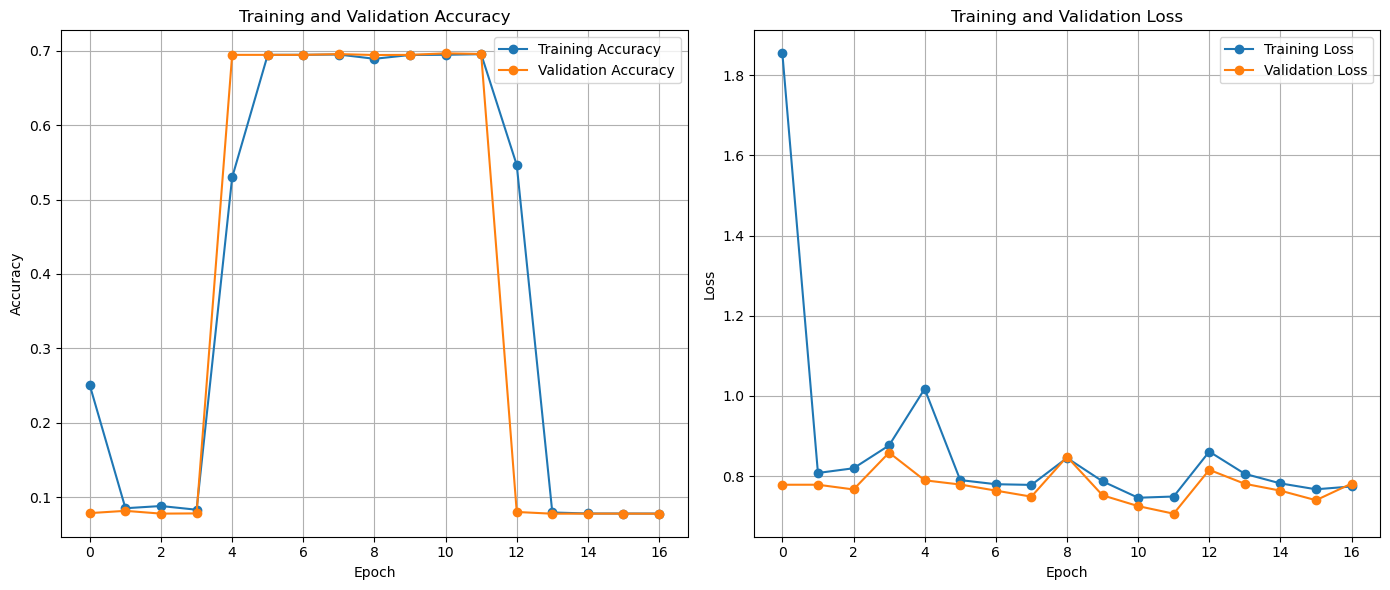

In [24]:
# Predict on test data
y_pred = model.predict({
    'description_input': padded_desc_test,
    'features_input': padded_feat_test,
    'structured_input': X_test_scaled
})

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

plot_training_history(history)

In [25]:
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1score = f1_score(y_true_classes, y_pred_classes, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1score}")

Accuracy: 0.6956609894566099
Precision: 0.5783305227027813
Recall: 0.6956609894566099
F1 Score: 0.5819551885104183
